In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import boxcox

In [42]:
dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")

In [43]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [44]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [45]:
series = dowjones_closing['Close']

In [46]:
series = boxcox(series, 0)

In [47]:
series = series[1:] - series[:-1]

Results of Dickey-Fuller Test:
Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


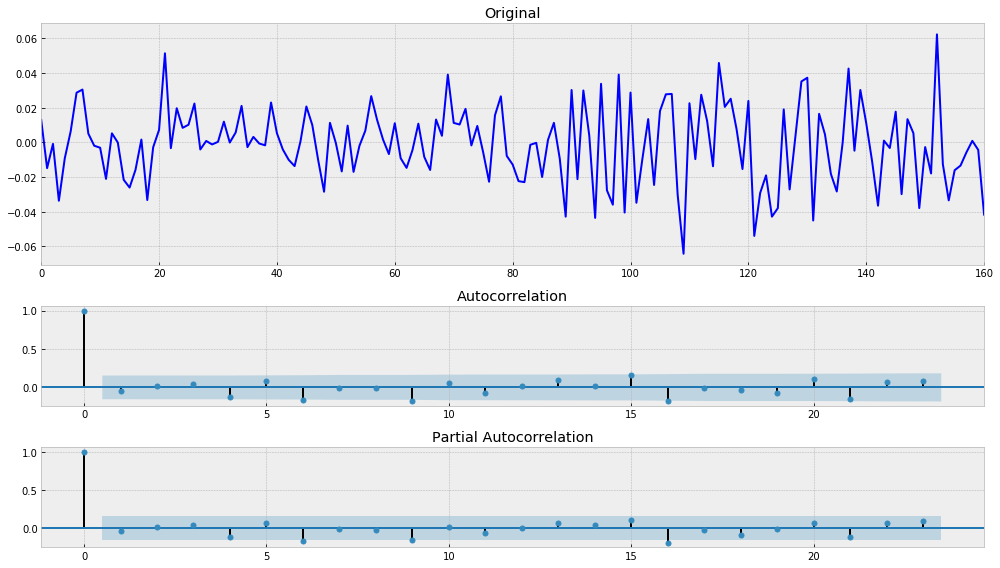

In [48]:
tsplot(series)

После всех преобразований получили стационарный ряд. Теперь создадим moving average:

In [49]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [65]:
ser = moving_average(dowjones_closing["Close"], 3) 

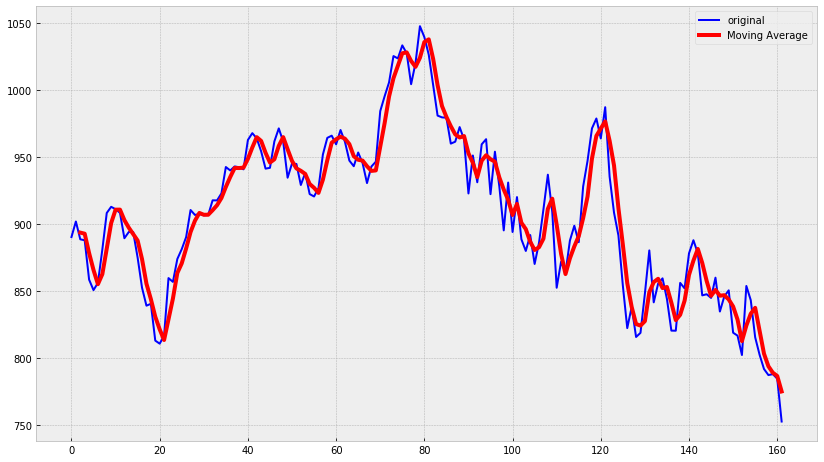

In [66]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(dowjones_closing["Close"], color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

Теперь попробуем приблизить moving average к стационарному ряду

In [67]:
ser_nonst = moving_average(series, 3)

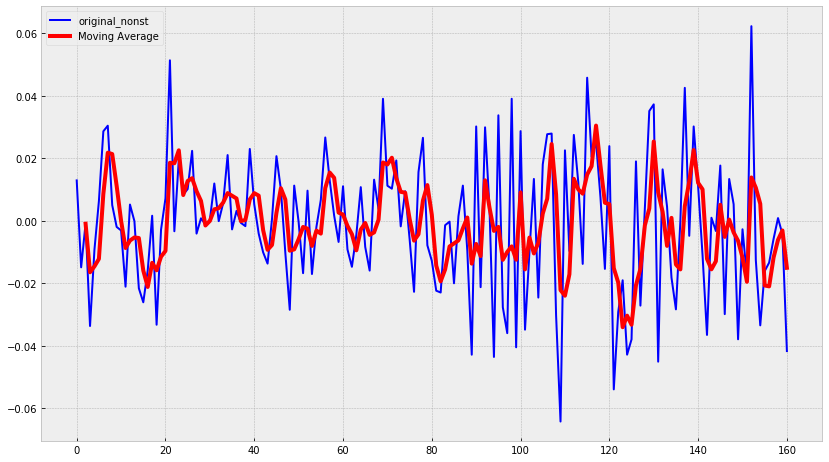

In [68]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original_nonst')
    plt.plot(ser_nonst, color='red', linewidth='4', label='Moving Average')
    plt.legend()

Посмотрим, как можно приблизить кривую оригинальных данных кривой moving average на различных окнах:

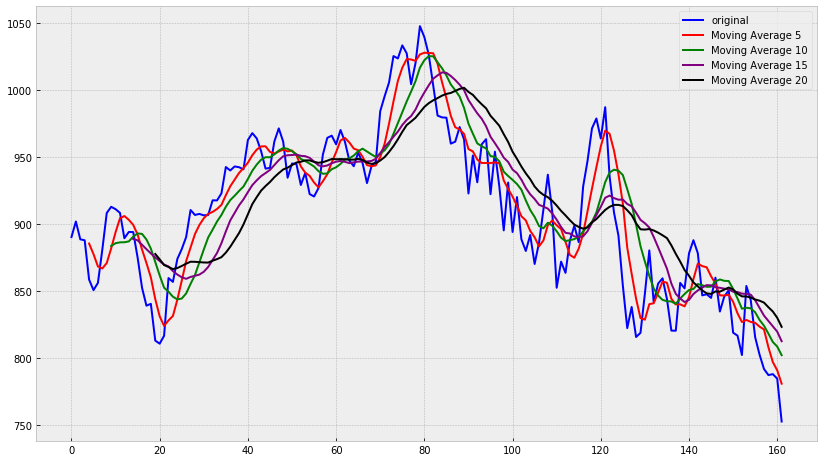

In [12]:
windows = [5,10,15,20]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(dowjones_closing["Close"], color='blue',label='original')
    for i in range(len(windows)):
        ser = moving_average(dowjones_closing["Close"], windows[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='Moving Average {}'.format(windows[i]))
    plt.legend()

Чем меньше окно, тем ближе линия к оригинальным данным.

Теперь определим экпоненциальную скользящую среднюю и двойную экспоненциальную скользящую среднюю для стационарного ряда:

In [13]:
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)

In [14]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

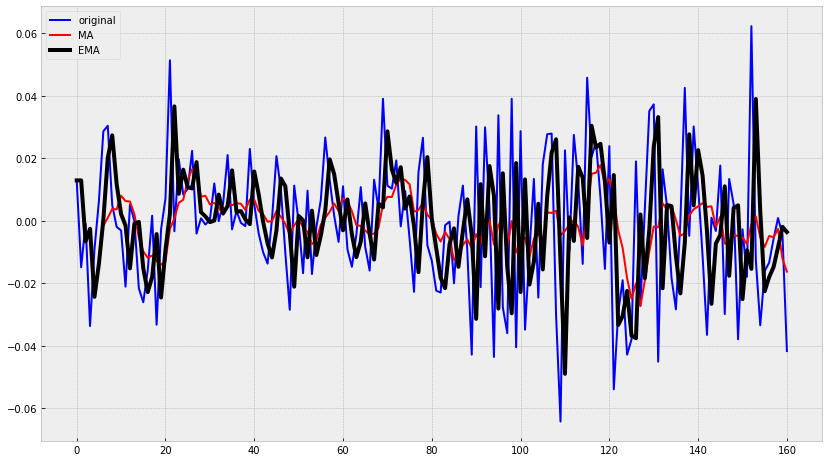

In [15]:
ema = exponential_moving_average(series, 0.7)
ma = moving_average(series, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

In [69]:
def plot_dema(alpha, beta):
    dema = double_ema(dowjones_closing["Close"], alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(dowjones_closing["Close"], color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

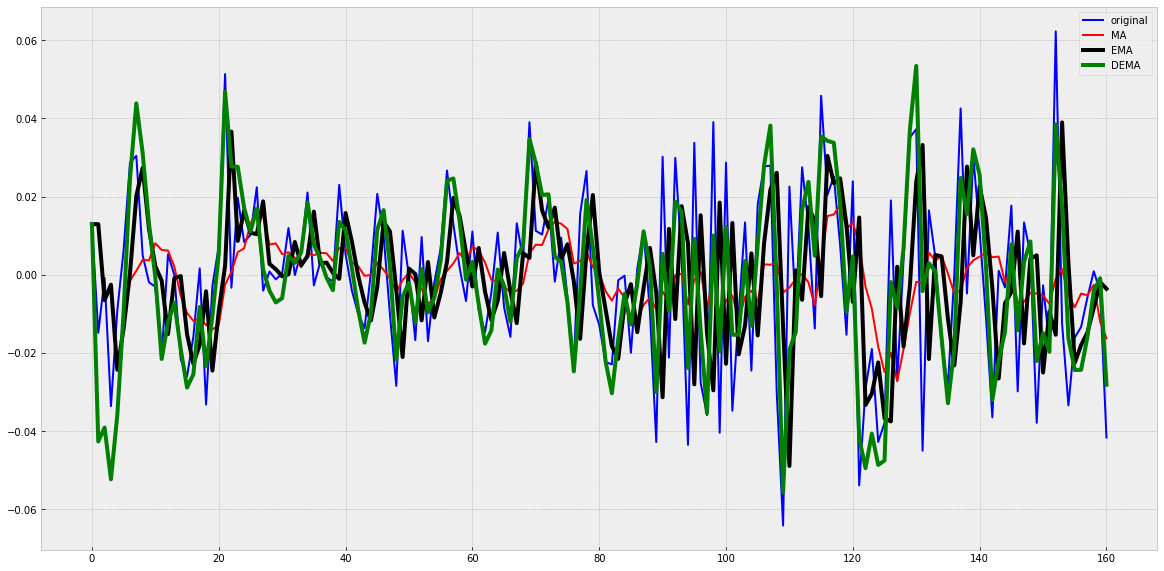

In [70]:
with plt.style.context('bmh'):
    plt.figure(figsize=(20, 10))
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.plot(double_ema(series, 0.5, 0.5), color='green', linewidth='4', label='DEMA')
    plt.legend()

In [76]:
from statsmodels.tools.eval_measures import rmse
error1 = rmse(series, ema)
error2 = rmse(series, double_ema(series, 0.5, 0.5))
print(error1, error2)

0.027676447054824135 0.013315279797882667


Ошибка ниже у двойной экспоненциальной скользящей средней.